# 使用 TensorFlow 的基本步骤

### 学习目标：

- 学习基本的 TensorFlow 概念
- 在 TensorFlow 中使用 LinearRegressor 类并基于单个输入特征预测各城市街区的房屋价值中位数
- 使用均方根误差 (RMSE) 评估模型预测的准确率
- 通过调整模型的超参数提高模型准确率

## 设置

In [5]:
import math

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics # Scikit learn 也简称 sklearn, 是机器学习领域当中最知名的 python 模块之一.
import tensorflow as tf

In [6]:
from tensorflow.python.data import Dataset #  需要tf 1.3 + 版本

In [7]:
tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

加载数据集

In [21]:
california_housing_dataframe = pd.read_csv("california_housing_train.csv", sep=",") # 例子中的网址连接不上，下载到本地用

我们将对数据进行随机化处理，以确保不会出现任何病态排序结果（可能会损害随机梯度下降法的效果）。

此外，我们会将 median_house_value 调整为以千为单位，这样，模型就能够以常用范围内的学习速率较为轻松地学习这些数据。

In [9]:
california_housing_dataframe = california_housing_dataframe.reindex(
    np.random.permutation(california_housing_dataframe.index))
california_housing_dataframe["median_house_value"] /= 1000.0
california_housing_dataframe

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
5474,-118.2,33.9,6.0,3445.0,847.0,2467.0,712.0,3.2,144.0
6526,-118.3,33.9,29.0,2587.0,489.0,2115.0,475.0,3.7,168.6
12702,-121.8,38.0,4.0,5623.0,780.0,2429.0,716.0,5.4,205.1
3402,-117.9,33.6,31.0,5488.0,1055.0,1938.0,964.0,8.9,500.0
5878,-118.2,33.9,43.0,1381.0,278.0,1494.0,298.0,3.6,118.4
...,...,...,...,...,...,...,...,...,...
4379,-118.0,33.9,31.0,1922.0,329.0,1030.0,353.0,5.3,213.0
13601,-122.0,38.0,12.0,5048.0,1122.0,2209.0,1014.0,3.2,126.7
174,-116.3,34.1,37.0,452.0,109.0,184.0,59.0,3.7,65.8
5516,-118.2,34.1,37.0,2246.0,481.0,995.0,459.0,4.3,354.7


## 检查数据

输出关于各列的一些实用统计信息快速摘要：样本数、均值、标准偏差、最大值、最小值和各种分位数

In [10]:
california_housing_dataframe.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0
mean,-119.6,35.6,28.6,2643.7,539.4,1429.6,501.2,3.9,207.3
std,2.0,2.1,12.6,2179.9,421.5,1147.9,384.5,1.9,116.0
min,-124.3,32.5,1.0,2.0,1.0,3.0,1.0,0.5,15.0
25%,-121.8,33.9,18.0,1462.0,297.0,790.0,282.0,2.6,119.4
50%,-118.5,34.2,29.0,2127.0,434.0,1167.0,409.0,3.5,180.4
75%,-118.0,37.7,37.0,3151.2,648.2,1721.0,605.2,4.8,265.0
max,-114.3,42.0,52.0,37937.0,6445.0,35682.0,6082.0,15.0,500.0


# 构建第一个模型

在本练习中，我们将尝试预测 median_house_value(房屋价格中值)，它将是我们的标签（有时也称为目标）。我们将使用 total_rooms 作为输入特征。

注意：我们使用的是城市街区级别的数据，因此该特征表示相应街区的房间总数。

为了训练模型，我们将使用 TensorFlow Estimator API 提供的 LinearRegressor（线性回归） 接口。此 API 负责处理大量低级别模型搭建工作，并会提供执行模型训练、评估和推理的便利方法。

### 第 1 步：定义特征并配置特征列

为了将我们的训练数据导入 TensorFlow，我们需要指定每个特征包含的数据类型。在本练习及今后的练习中，我们主要会使用以下两类数据：

分类数据：一种文字数据。在本练习中，我们的住房数据集不包含任何分类特征，但您可能会看到的示例包括家居风格以及房地产广告词。

数值数据：一种数字（整数或浮点数）数据以及您希望视为数字的数据。有时您可能会希望将数值数据（例如邮政编码）视为分类数据（我们将在稍后的部分对此进行详细说明）。

在 TensorFlow 中，我们使用一种称为“特征列”的结构来表示特征的数据类型。特征列仅存储对特征数据的描述；不包含特征数据本身。

一开始，我们只使用一个数值输入特征 total_rooms。以下代码会从 california_housing_dataframe 中提取 total_rooms 数据，并使用 numeric_column 定义特征列，这样会将其数据指定为数值：

In [11]:
# Define the input feature: total_rooms.
my_feature = california_housing_dataframe[["total_rooms"]]

# Configure a numeric feature column for total_rooms.
feature_columns = [tf.feature_column.numeric_column("total_rooms")]

### 第 2 步：定义目标

接下来，我们将定义目标，也就是 median_house_value。同样，我们可以从 california_housing_dataframe 中提取它：

In [12]:
# Define the label.
targets = california_housing_dataframe["median_house_value"]

### 第 3 步：配置 LinearRegressor

接下来，我们将使用 LinearRegressor 配置线性回归模型，并使用 GradientDescentOptimizer（它会实现小批量随机梯度下降法 (SGD)）训练该模型。learning_rate 参数可控制梯度步长的大小。

注意：为了安全起见，我们还会通过 clip_gradients_by_norm 将梯度裁剪应用到我们的优化器。梯度裁剪可确保梯度大小在训练期间不会变得过大，梯度过大会导致梯度下降法失败。

In [13]:
# Use gradient descent as the optimizer for training the model.
my_optimizer=tf.train.GradientDescentOptimizer(learning_rate=0.0000001)
my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)

# Configure the linear regression model with our feature columns and optimizer.
# Set a learning rate of 0.0000001 for Gradient Descent.
linear_regressor = tf.estimator.LinearRegressor(
    feature_columns=feature_columns,
    optimizer=my_optimizer
)

### 第 4 步：定义输入函数

要将加利福尼亚州住房数据导入 LinearRegressor，我们需要定义一个输入函数，让它告诉 TensorFlow 如何对数据进行预处理，以及在模型训练期间如何批处理、随机处理和重复数据。

首先，我们将 Pandas 特征数据转换成 NumPy 数组字典。然后，我们可以使用 TensorFlow Dataset API 根据我们的数据构建 Dataset 对象，并将数据拆分成大小为 batch_size 的多批数据，以按照指定周期数 (num_epochs) 进行重复。

注意：如果将默认值 num_epochs=None 传递到 repeat()，输入数据会无限期重复。

然后，如果 shuffle 设置为 True，则我们会对数据进行随机处理，以便数据在训练期间以随机方式传递到模型。buffer_size 参数会指定 shuffle 将从中随机抽样的数据集的大小。

最后，输入函数会为该数据集构建一个迭代器，并向 LinearRegressor 返回下一批数据。

In [14]:
def my_input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    """Trains a linear regression model of one feature.
  
    Args:
      features: pandas DataFrame of features
      targets: pandas DataFrame of targets
      batch_size: Size of batches to be passed to the model
      shuffle: True or False. Whether to shuffle the data.
      num_epochs: Number of epochs for which data should be repeated. None = repeat indefinitely
    Returns:
      Tuple of (features, labels) for next data batch
    """
  
    # Convert pandas data into a dict of np arrays.
    features = {key:np.array(value) for key,value in dict(features).items()}                                           
 
    # Construct a dataset, and configure batching/repeating
    ds = Dataset.from_tensor_slices((features,targets)) # warning: 2GB limit
    ds = ds.batch(batch_size).repeat(num_epochs)
    
    # Shuffle the data, if specified
    if shuffle:
      ds = ds.shuffle(buffer_size=10000)
    
    # Return the next batch of data
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels

### 第 5 步：训练模型

现在，我们可以在 linear_regressor 上调用 train() 来训练模型。我们会将 my_input_fn 封装在 lambda 中，以便可以将 my_feature 和 target 作为参数传入（有关详情，请参阅此 TensorFlow 输入函数教程），首先，我们会训练 100 步。

In [15]:
_ = linear_regressor.train(
    input_fn = lambda:my_input_fn(my_feature, targets),
    steps=100
)

### 第 6 步：评估模型

我们基于该训练数据做一次预测，看看我们的模型在训练期间与这些数据的拟合情况。

注意：训练误差可以衡量您的模型与训练数据的拟合情况，但并不能衡量模型泛化到新数据的效果。在后面的练习中，您将探索如何拆分数据以评估模型的泛化能力。

In [16]:
# Create an input function for predictions.
# Note: Since we're making just one prediction for each example, we don't 
# need to repeat or shuffle the data here.
prediction_input_fn =lambda: my_input_fn(my_feature, targets, num_epochs=1, shuffle=False)

# Call predict() on the linear_regressor to make predictions.
predictions = linear_regressor.predict(input_fn=prediction_input_fn)

# Format predictions as a NumPy array, so we can calculate error metrics.
predictions = np.array([item['predictions'][0] for item in predictions])

# Print Mean Squared Error and Root Mean Squared Error.
mean_squared_error = metrics.mean_squared_error(predictions, targets)
root_mean_squared_error = math.sqrt(mean_squared_error)
print ("Mean Squared Error (on training data): %0.3f" % mean_squared_error)
print ("Root Mean Squared Error (on training data): %0.3f" % root_mean_squared_error)

Mean Squared Error (on training data): 56367.025
Root Mean Squared Error (on training data): 237.417


这是出色的模型吗？您如何判断误差有多大？

由于均方误差 (MSE) 很难解读，因此我们经常查看的是均方根误差 (RMSE)。RMSE 的一个很好的特性是，它可以在与原目标相同的规模下解读。

我们来比较一下 RMSE 与目标最大值和最小值的差值：

In [17]:
min_house_value = california_housing_dataframe["median_house_value"].min()
max_house_value = california_housing_dataframe["median_house_value"].max()
min_max_difference = max_house_value - min_house_value

print ("Min. Median House Value: %0.3f" % min_house_value)
print ("Max. Median House Value: %0.3f" % max_house_value)
print ("Difference between Min. and Max.: %0.3f" % min_max_difference)
print ("Root Mean Squared Error: %0.3f" % root_mean_squared_error)

Min. Median House Value: 14.999
Max. Median House Value: 500.001
Difference between Min. and Max.: 485.002
Root Mean Squared Error: 237.417


我们的误差跨越目标值的近一半范围，可以进一步缩小误差吗？

这是每个模型开发者都会烦恼的问题。我们来制定一些基本策略，以降低模型误差。

首先，我们可以了解一下根据总体摘要统计信息，预测和目标的符合情况。

In [18]:
calibration_data = pd.DataFrame()
calibration_data["predictions"] = pd.Series(predictions)
calibration_data["targets"] = pd.Series(targets)
calibration_data.describe()

,predictions,targets
count,17000.0,17000.0
mean,0.1,207.3
std,0.1,116.0
min,0.0,15.0
25%,0.1,119.4
50%,0.1,180.4
75%,0.2,265.0
max,1.9,500.0


好的，此信息也许有帮助。平均值与模型的 RMSE 相比情况如何？各种分位数呢？

我们还可以将数据和学到的线可视化。我们已经知道，单个特征的线性回归可绘制成一条将输入 x 映射到输出 y 的线。

首先，我们将获得均匀分布的随机数据样本，以便绘制可辨的散点图。

In [19]:
sample = california_housing_dataframe.sample(n=300)

然后，我们根据模型的偏差项和特征权重绘制学到的线，并绘制散点图。该线会以红色显示。

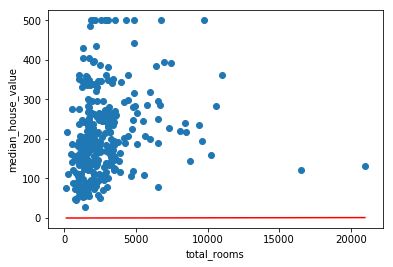

In [20]:
# Get the min and max total_rooms values.
x_0 = sample["total_rooms"].min()
x_1 = sample["total_rooms"].max()

# Retrieve the final weight and bias generated during training.
weight = linear_regressor.get_variable_value('linear/linear_model/total_rooms/weights')[0]
bias = linear_regressor.get_variable_value('linear/linear_model/bias_weights')

# Get the predicted median_house_values for the min and max total_rooms values.
y_0 = weight * x_0 + bias 
y_1 = weight * x_1 + bias

# Plot our regression line from (x_0, y_0) to (x_1, y_1).
plt.plot([x_0, x_1], [y_0, y_1], c='r')

# Label the graph axes.
plt.ylabel("median_house_value")
plt.xlabel("total_rooms")

# Plot a scatter plot from our data sample.
plt.scatter(sample["total_rooms"], sample["median_house_value"])

# Display graph.
plt.show()

这条初始线看起来与目标相差很大。看看您能否回想起摘要统计信息，并看到其中蕴含的相同信息。

综上所述，这些初始健全性检查提示我们也许可以找到更好的线。

对于本练习，为方便起见，我们已将上述所有代码放入一个函数中。您可以使用不同的参数调用该函数，以了解相应效果。

我们会在 10 个等分的时间段内使用此函数，以便观察模型在每个时间段的改善情况。

对于每个时间段，我们都会计算训练损失并绘制相应图表。这可以帮助您判断模型收敛的时间，或者模型是否需要更多迭代。

此外，我们还会绘制模型随着时间的推移学习的特征权重和偏差项值的曲线图。您还可以通过这种方式查看模型的收敛效果。

## 调整模型超参数

In [24]:
def train_model(learning_rate, steps, batch_size, input_feature="total_rooms"):
  """Trains a linear regression model of one feature.
  
  Args:
    learning_rate: A `float`, the learning rate.
    steps: A non-zero `int`, the total number of training steps. A training step
      consists of a forward and backward pass using a single batch.
    batch_size: A non-zero `int`, the batch size.
    input_feature: A `string` specifying a column from `california_housing_dataframe`
      to use as input feature.
  """
  
  periods = 10
  steps_per_period = steps / periods

  my_feature = input_feature
  my_feature_data = california_housing_dataframe[[my_feature]]
  my_label = "median_house_value"
  targets = california_housing_dataframe[my_label]

  # Create feature columns
  feature_columns = [tf.feature_column.numeric_column(my_feature)]
  
  # Create input functions
  training_input_fn = lambda:my_input_fn(my_feature_data, targets, batch_size=batch_size)
  prediction_input_fn = lambda: my_input_fn(my_feature_data, targets, num_epochs=1, shuffle=False)
  
  # Create a linear regressor object.
  my_optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
  my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
  linear_regressor = tf.estimator.LinearRegressor(
      feature_columns=feature_columns,
      optimizer=my_optimizer
  )

  # Set up to plot the state of our model's line each period.
  plt.figure(figsize=(15, 6))
  plt.subplot(1, 2, 1)
  plt.title("Learned Line by Period")
  plt.ylabel(my_label)
  plt.xlabel(my_feature)
  sample = california_housing_dataframe.sample(n=300)
  plt.scatter(sample[my_feature], sample[my_label])
  colors = [cm.coolwarm(x) for x in np.linspace(-1, 1, periods)]

  # Train the model, but do so inside a loop so that we can periodically assess
  # loss metrics.
  print ("Training model...")
  print ("RMSE (on training data):")
  root_mean_squared_errors = []
  for period in range (0, periods):
    # Train the model, starting from the prior state.
    linear_regressor.train(
        input_fn=training_input_fn,
        steps=steps_per_period
    )
    # Take a break and compute predictions.
    predictions = linear_regressor.predict(input_fn=prediction_input_fn)
    predictions = np.array([item['predictions'][0] for item in predictions])
    
    # Compute loss.
    root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(predictions, targets))
    # Occasionally print the current loss.
    print ("  period %02d : %0.2f" % (period, root_mean_squared_error))
    # Add the loss metrics from this period to our list.
    root_mean_squared_errors.append(root_mean_squared_error)
    # Finally, track the weights and biases over time.
    # Apply some math to ensure that the data and line are plotted neatly.
    y_extents = np.array([0, sample[my_label].max()])
    
    weight = linear_regressor.get_variable_value('linear/linear_model/%s/weights' % input_feature)[0]
    bias = linear_regressor.get_variable_value('linear/linear_model/bias_weights')

    x_extents = (y_extents - bias) / weight
    x_extents = np.maximum(np.minimum(x_extents,
                                      sample[my_feature].max()),
                           sample[my_feature].min())
    y_extents = weight * x_extents + bias
    plt.plot(x_extents, y_extents, color=colors[period]) 
  print ("Model training finished.")

  # Output a graph of loss metrics over periods.
  plt.subplot(1, 2, 2)
  plt.ylabel('RMSE')
  plt.xlabel('Periods')
  plt.title("Root Mean Squared Error vs. Periods")
  plt.tight_layout()
  plt.plot(root_mean_squared_errors)

  # Output a table with calibration data.
  calibration_data = pd.DataFrame()
  calibration_data["predictions"] = pd.Series(predictions)
  calibration_data["targets"] = pd.Series(targets)
  display.display(calibration_data.describe())

  print ("Final RMSE (on training data): %0.2f" % root_mean_squared_error)

## 任务 1：使 RMSE 不超过 180

In [25]:
train_model(
    learning_rate=0.00001,
    steps=100,
    batch_size=1
)

Training model...
RMSE (on training data):
  period 00 : 237538.48
  period 01 : 237537.26
  period 02 : 237536.03
  period 03 : 237534.81
  period 04 : 237533.59
  period 05 : 237532.36
  period 06 : 237531.14
  period 07 : 237529.92
  period 08 : 237528.69
  period 09 : 237527.47
Model training finished.


,predictions,targets
count,17000.0,17000.0
mean,13.2,207300.9
std,10.9,115983.8
min,0.0,14999.0
25%,7.3,119400.0
50%,10.6,180400.0
75%,15.8,265000.0
max,189.7,500001.0


Final RMSE (on training data): 237527.47


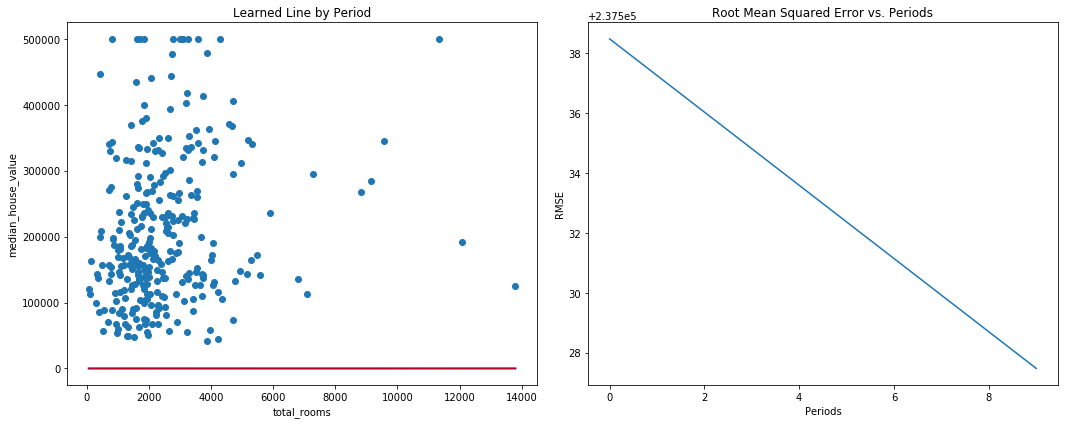

In [26]:
plt.show()

## 任务 2：尝试其他特征

In [27]:
train_model(
    learning_rate=0.00002,
    steps=1000,
    batch_size=5,
    input_feature="population"
)

Training model...
RMSE (on training data):
  period 00 : 237527.38
  period 01 : 237515.07
  period 02 : 237502.75
  period 03 : 237490.43
  period 04 : 237478.11
  period 05 : 237465.80
  period 06 : 237453.48
  period 07 : 237441.17
  period 08 : 237428.86
  period 09 : 237416.54
Model training finished.


,predictions,targets
count,17000.0,17000.0
mean,143.0,207300.9
std,114.8,115983.8
min,0.3,14999.0
25%,79.0,119400.0
50%,116.7,180400.0
75%,172.1,265000.0
max,3568.2,500001.0


Final RMSE (on training data): 237416.54


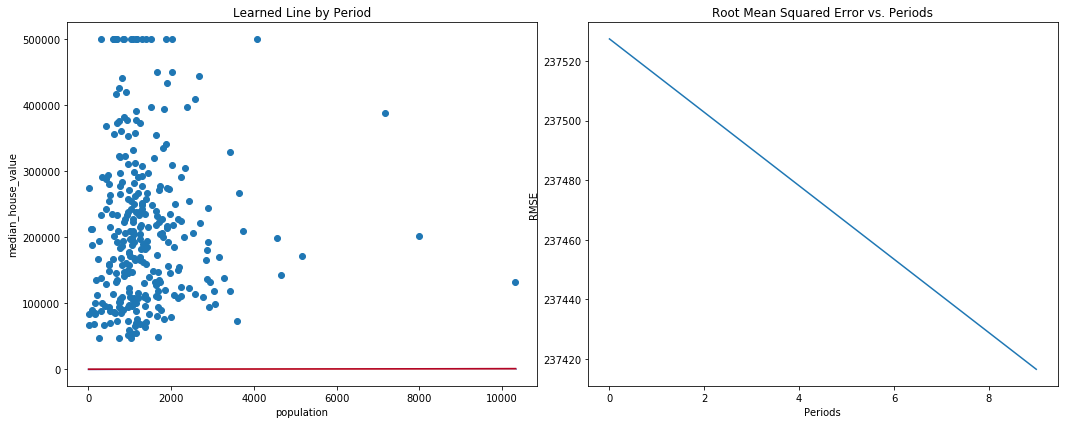

In [28]:
plt.show()